
 Susnata's Customer Segmentation with Gaussian Mixture Models (GMM)

In this notebook, I segment retail customers using RFM metrics
(Recency, Frequency, Monetary).

- RFM captures how recently, how often, and how much a customer buys.
- GMM (Gaussian Mixture Model) is used because it allows **soft clustering**:
  each customer gets probabilities of belonging to different segments.
- I chose **4 clusters** based on AIC/BIC analysis for a balance of
  accuracy and interpretability.

Goal: Identify customer groups (e.g. VIPs, Occasional Buyers, Window Shoppers)
to enable targeted marketing strategies and personalized engagement.


In [ ]:
!pip install plotly

In [2]:
#Importing  necessary packages

import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import plotly.express as px

In [3]:
from google.colab import files
uploaded = files.upload()

Saving customer_segmentation.csv to customer_segmentation.csv


In [4]:
df = pd.read_csv('customer_segmentation.csv') #dataframe

In [5]:
#Quick check of dataframe

print("Columns:", df.columns.tolist())


Columns: ['index', 'InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [6]:
print("Initial shape:", df.shape)
df.head()

Initial shape: (541909, 9)


,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:
 #Quick Data Quality Check being done by me

# Missing values per column
print("Missing values per column:")
print(df.isnull().sum())

# Seeing Total missing values
print("\nTotal missing values:", df.isnull().sum().sum())

# Duplicate rows
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Unique values per column
print("\nUnique values per column:")
print(df.nunique())

# Data types and non-null counts
print("\nData info:")
print(df.info())

Missing values per column:
index          0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Total missing values: 0

Number of duplicate rows: 0

Unique values per column:
index          406829
InvoiceNo       22190
StockCode        3684
Description      3896
Quantity          436
InvoiceDate     20460
UnitPrice         620
CustomerID       4372
Country            37
dtype: int64

Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        406829 non-null  int64  
 1   InvoiceNo    406829 non-null  object 
 2   StockCode    406829 non-null  object 
 3   Description  406829 non-null  object 
 4   Quantity     406829 non-null  int64  
 5   InvoiceDate  406829 non-null  object 
 6   UnitPrice    406829 non-null  float64
 7   Custom

In [10]:
# dropping missing customer ids as they maybe guest checkouts but to do customer segmentation we need customer id
#There are 135k such
df = df.dropna(subset=['CustomerID'])

In [11]:
# we will not actually use Description in RFM or GMM (it’s more for product-level analysis)so fillimg unknown

df['Description'] = df['Description'].fillna("Unknown")

In [12]:
df = df.drop_duplicates()

In [13]:
df.shape

(406829, 9)

RFM FEATURE ENGINEERING ,RECENY FREQUENCY MONETARY

In [14]:
# keeping only positive quantities (ignore returns or negative values)
df = df[df['Quantity'] > 0]

In [15]:
# parsing invoice date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

In [16]:
# creating  total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [17]:
# Snapshot date = one day after last invoice This is a common RFM approach to maintain consistency
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [18]:
# Aggregating to RFM per CustomerID
rfm = df.groupby('CustomerID').agg(
    Recency = ('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('InvoiceNo', 'nunique'),# how many invoices per cx
    Monetary = ('TotalPrice', 'sum')
).reset_index()

In [ ]:
#How much recent cx purchase is ,How frequent the customer is and how much monetary value has they expended

In [21]:
rfm.shape  # rfm 4339 cx along with 4 columns

(4339, 4)

In [45]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [46]:
#Data transformations (log transformations  & scale saving a copy
rfm_model = rfm.copy()

In [47]:
#Using  log1p for Monetary to handle zero values safely as log 0 is undefined and
#Log transformation will help with exteme skewed values
#log1p is log plus 1


rfm_model['Monetary_log'] = np.log1p(rfm_model['Monetary'])


In [48]:
# Choosing  features (we keep original Monetary column too)
features = ['Recency', 'Frequency', 'Monetary_log']
X = rfm_model[features].values  # converting to numpy


In [49]:
# Standardizimng for GMM underhodd GMM uses Mahanobalis distance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled data shape:", X_scaled.shape)

Scaled data shape: (4339, 3)


In [50]:
#  GMM model selection via AIC / BIC  Akeki focuses on accuracy and Bayesian focuses on easy model does away with complexity
ks = range(2, 9)   # try 2 to 8 components ,Its like selecting number of Gausians and k in k means
aics = []
bics = []
gmms = []
for k in ks:
    g = GaussianMixture(n_components=k, covariance_type='full', random_state=42, n_init=5, max_iter=300)
    g.fit(X_scaled)
    aics.append(g.aic(X_scaled))
    bics.append(g.bic(X_scaled))
    gmms.append(g)
    print(f"k={k} fitted, AIC={aics[-1]:.1f}, BIC={bics[-1]:.1f}")

# covariance full give highest flexibility to eaach gausian to have its own shape mostly elliptical along with mean vector
#Other options like tied all clusters same CM, diag where diag elements are used ,and spherical least flexible
# n iter numer of timesgmm will run with different  random initializations
#Max iter focuses on max  numnber of Expectations Maximizations

k=2 fitted, AIC=22622.5, BIC=22743.6
k=3 fitted, AIC=19318.2, BIC=19503.1
k=4 fitted, AIC=6947.5, BIC=7196.1
k=5 fitted, AIC=6123.3, BIC=6435.7
k=6 fitted, AIC=5423.6, BIC=5799.8
k=7 fitted, AIC=-1102.7, BIC=-662.8
k=8 fitted, AIC=-4745.0, BIC=-4241.3


In [ ]:
#Full in CM  customers with h frequency also might have h Monetary spend corelation
#FUll lets GMM capture that
#If we uused others i am saying other feature are uncorrelated which is rarely true

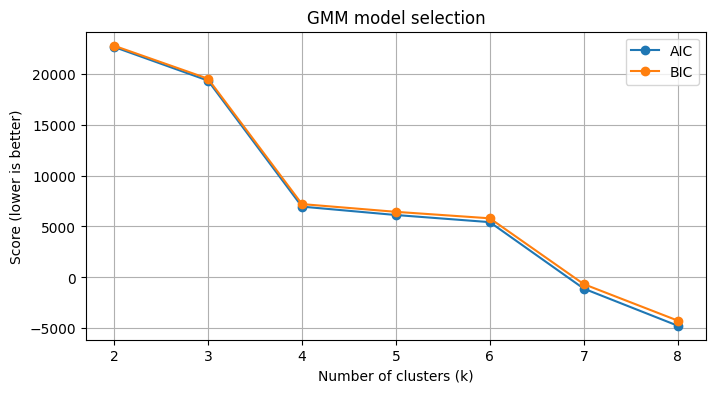

In [51]:
#Plotting AIC/BIC
plt.figure(figsize=(8,4))
plt.plot(list(ks), aics, marker='o', label='AIC')
plt.plot(list(ks), bics, marker='o', label='BIC')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score (lower is better)')
plt.title('GMM model selection')
plt.legend()
plt.grid(True)
plt.show()

 GMM Model Selection via AIC & BIC

- This graph compares AIC (blue) and BIC (orange) across different
  numbers of clusters (k).

- Both AIC and BIC drop sharply up to k=4, showing big improvement
  in model fit. After that, the curve flattens (diminishing returns).

- Although the absolute minimum is at higher k (7–8), BIC suggests
  that k=4 is a good balance between accuracy and simplicity.

✅ Decision:
We will go with **4 clusters** to keep segmentation interpretable
for business use cases.

✔😃
In GMM, each customer is assigned to a cluster with a probability
distribution.
- Example: CustomerID 123 → [Cluster0=0.05, Cluster1=0.10, Cluster2=0.80, Cluster3=0.05]
- Probabilities always sum to 1.
- The "hard" cluster label is simply the cluster with the highest probability.


In [ ]:
# 📌 Final GMM with fixed k = 4

from sklearn.mixture import GaussianMixture

# Fit GMM directly with 4 clusters
gmm = GaussianMixture(
    n_components=4,
    covariance_type='full',
    random_state=42,
    n_init=5,
    max_iter=300
)
gmm.fit(X_scaled)

In [53]:
# 📌 Assign clusters & probabilities

rfm_model['Cluster'] = gmm.predict(X_scaled)


In [54]:
rfm_model.head()

,CustomerID,Recency,Frequency,Monetary,Monetary_log,Cluster
0,12346.0,326,1,77183.60,11.253955,1
1,12347.0,2,7,4310.00,8.368925,0
2,12348.0,75,4,1797.24,7.494564,3
3,12349.0,19,1,1757.55,7.472245,1
4,12350.0,310,1,334.40,5.815324,1


In [55]:
# Soft clustering: probability distribution for each customer
probs = gmm.predict_proba(X_scaled) #predict proba sums up to 1
rfm_model['Confidence'] = probs.max(axis=1)  # highest probability = confidence/hard cluster
for i in range(4):
    rfm_model[f'prob{i}'] = probs[:, i]

# Ensure CustomerID column is visible
rfm_model = rfm_model.reset_index(drop=True)

In [56]:
rfm_model.head()

,CustomerID,Recency,Frequency,Monetary,Monetary_log,Cluster,Confidence,prob0,prob1,prob2,prob3
0,12346.0,326,1,77183.60,11.253955,1,0.999962,9.417000e-39,0.999962,0.000000e+00,0.000038
1,12347.0,2,7,4310.00,8.368925,0,0.875080,8.750800e-01,0.000000,1.247802e-01,0.000140
2,12348.0,75,4,1797.24,7.494564,3,0.718368,2.816321e-01,0.000000,4.286846e-30,0.718368
3,12349.0,19,1,1757.55,7.472245,1,0.960242,3.594429e-02,0.960242,9.137168e-04,0.002900
4,12350.0,310,1,334.40,5.815324,1,0.999734,1.647546e-30,0.999734,0.000000e+00,0.000266


In [58]:
#  Cluster centers of gausians  (in original RFM units)

centers_scaled = gmm.means_
centers_unscaled = scaler.inverse_transform(centers_scaled) # doimng reverse transform as we did scaling

centers_df = pd.DataFrame(centers_unscaled, columns=['Recency','Frequency','Monetary_log'])
centers_df['Monetary'] = np.expm1(centers_df['Monetary_log'])  # reverse log1p
centers_df = centers_df[['Recency','Frequency','Monetary']].round(2)
centers_df['Cluster'] = range(4)

print("Cluster centers (original RFM units):")
centers_df

Cluster centers (original RFM units):


,Recency,Frequency,Monetary,Cluster
0,26.72,6.03,1704.78,0
1,156.82,1.00,254.63,1
2,6.80,23.83,8566.39,2
3,100.73,2.76,660.25,3


In [62]:
# 📌 Cluster summary table

summary = rfm_model.groupby('Cluster').agg(
    Count = ('CustomerID','count'),
    AvgRecency = ('Recency','mean'),
    AvgFrequency = ('Frequency','mean'),
    AvgMonetary = ('Monetary','mean'),
    AvgConfidence = ('Confidence','mean')
).round(3)
print("Cluster summary:")
display(summary)

Cluster summary:


,Count,AvgRecency,AvgFrequency,AvgMonetary,AvgConfidence
Cluster,,,,,
0,1397,24.646,6.034,2293.933,0.824
1,1494,156.587,1.000,412.525,0.997
2,203,6.635,26.158,19469.354,0.925
3,1245,105.798,2.652,914.211,0.871


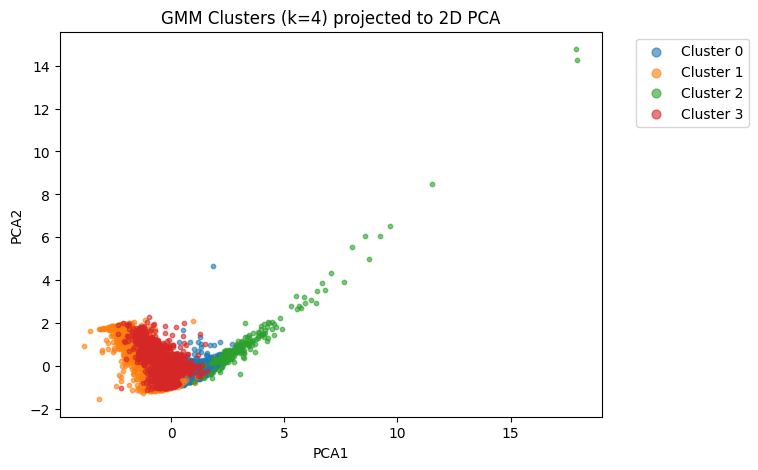

In [63]:
# 2D PCA visualization
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)
rfm_model['PCA1'], rfm_model['PCA2'] = X_pca2[:,0], X_pca2[:,1]

plt.figure(figsize=(7,5))
for c in range(4):
    mask = rfm_model['Cluster'] == c
    plt.scatter(rfm_model.loc[mask,'PCA1'], rfm_model.loc[mask,'PCA2'], s=10, alpha=0.6, label=f'Cluster {c}')
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.title("GMM Clusters (k=4) projected to 2D PCA")
plt.legend(markerscale=2, bbox_to_anchor=(1.05,1))
plt.show()

In [ ]:
# 3D PCA interactive (Plotly) choosing 3 as RFM
pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X_scaled)
plot_df = pd.DataFrame(X_pca3, columns=['PC1','PC2','PC3'])
plot_df['Cluster'] = rfm_model['Cluster'].astype(str)
plot_df['CustomerID'] = rfm_model['CustomerID'].astype(str)

fig = px.scatter_3d(
    plot_df, x='PC1', y='PC2', z='PC3',
    color='Cluster', hover_name='CustomerID',
    title="3D PCA Projection of GMM Clusters (k=4)"
)
fig.show()

In [70]:
# I am Adding  short, business-friendly labels to clusters by seeing the summary table
cluster_labels = {
    0: "Loyal regulars",  # consitent mid spendersa but still engaged
    1: "Window Shoppers",# One time very low spend not very active
    2: "VIP Customers (Heavy Shoppers)", # high value ,Very frequent, Very recent
    3: "At risk customers"# used to buy but inactive now very small spend
}

summary['Cluster_Label'] = summary.index.map(cluster_labels)
print("Cluster summary with labels:")
display(summary)

Cluster summary with labels:


,Count,AvgRecency,AvgFrequency,AvgMonetary,AvgConfidence,Cluster_Label
Cluster,,,,,,
0,1397,24.646,6.034,2293.933,0.824,Loyal regulars
1,1494,156.587,1.000,412.525,0.997,Window Shoppers
2,203,6.635,26.158,19469.354,0.925,VIP Customers (Heavy Shoppers)
3,1245,105.798,2.652,914.211,0.871,At risk customers


📌 Conclusion

I successfully segmented customers into **4 groups** using GMM on RFM data.
- Each customer is assigned a cluster with a probability distribution (soft clustering).
- This allows us to not only classify customers but also understand the confidence
  of their membership.

Cluster Insights:
-----------------
1 VIP Customers (Heavy Shoppers): Loyal, frequent buyers with high spend.
   👉 Target with rewards, loyalty programs, early access sales.


2 At Risk Customers: Haven’t shopped recently, low activity.
   👉 Re-engagement campaigns, special offers to bring them back.

3 LoyalRegulars
   👉 Cross-sell, upsell opportunities, nurture them into VIPs.

4 Window Shoppers Low spend, low frequency.
   👉 Low-priority, but can be nudged with discounts to increase activity.

Business Impact:
----------------
This segmentation allows personalized marketing strategies,
better allocation of promotional budget, and stronger customer retention efforts.
